<a href="https://colab.research.google.com/github/nadiaza24/hello-world/blob/master/ANC_Emulator_PyTorch_10000runs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Mosquito Dynamics from Clinical Incidence: A Machine Learning Approach

*italicized text*## Load packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random

import time
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

In [ ]:
print(torch.__version__)

2.8.0+cu126


In [ ]:
# Set seeds for reproducibility
torch.manual_seed(2)
np.random.seed(2)
random.seed(2)

In [ ]:
print("Is CUDA available? ", torch.cuda.is_available())
print("GPU count: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

Is CUDA available?  True
GPU count:  1
GPU Name:  Tesla T4


## Data

In [ ]:
df = pd.read_csv("drive/MyDrive/MalariaEmulator/ANC_Simulation_10000_runs_new.csv", index_col=0).reset_index(drop=True)

In [ ]:
df = df[df['run'] <= 10000]

In [ ]:
df.tail()

,run,t,prev_true,EIR_true,vol_true,tested,positive,prev_2to10,inc_2to10,incall
2439995,10000,7200,0.401790,35.774678,0.2,251,96,0.529254,0.006434,0.005600
2439996,10000,7230,0.388319,29.737731,0.2,185,70,0.515979,0.005412,0.004690
2439997,10000,7260,0.378049,23.332502,0.2,202,75,0.504926,0.004237,0.003661
2439998,10000,7290,0.363994,32.938459,0.2,184,73,0.488525,0.005997,0.005170
2439999,10000,7320,0.373010,47.263925,0.2,203,67,0.499720,0.008261,0.007119


In [ ]:
df = df[df['run'] <= 10000]
#df = df[(df['t'] >= 3650) & (df['t'] <= 7320)]
#df = process_dataframe(df)
df.shape

(2440000, 10)

## Exploratory Data Analysis

### Functions to plot cross correlation and simulated data

In [ ]:
#Function to plot simulated data (Exploratory Data Analysis)
def plot_subplots_for_runs(df, num_runs=20):
    # Convert time column to years
    df = df.copy()
    df['t_years'] = df['t'] / 365  # Convert days to years

    # Select the first num_runs unique runs
    unique_runs = df['run'].unique()[:num_runs]
    columns_to_plot = ["incall", "EIR_true"]

    # Define distinct colors for the three columns
    color_map = {
        'incall': 'tab:orange',
        'EIR_true': 'tab:green'
    }

    # Define grid size for subplots (4 subplots per row)
    rows = (num_runs - 1) // 4 + 1
    cols = 4

    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    axes = axes.flatten()  # Flatten for easy iteration

    for i, run in enumerate(unique_runs):
        ax = axes[i]

        # Extract and sort data for the run by time
        run_data = df[df['run'] == run].sort_values('t_years')
        monthly = run_data.sort_values('t_years')

        # Plot monthly observation data as lines for each column
        for col in columns_to_plot:
            # Plot the monthly data as a solid line
            ax.plot(monthly['t_years'], monthly[col],
                    color=color_map[col],
                    lw=2,
                    label=f'{col} (Monthly)' if i == 0 else None)

        # Set the y-axis to a logarithmic scale for better comparison
        ax.set_yscale('log')

        # Set subplot title and labels
        ax.set_title(f'Run {run}')
        ax.set_xlabel('Time (years)')  # Updated label
        ax.set_ylabel('Values')
        ax.grid(True, which="both", ls="--", linewidth=0.5)

    # Hide any unused subplots
    for j in range(len(unique_runs), len(axes)):
        axes[j].axis('off')

    # Create a custom legend.
    custom_lines = [
        Line2D([0], [0], color=color_map['incall'], lw=2),
        Line2D([0], [0], color=color_map['EIR_true'], lw=2),
        Line2D([0], [0], marker='D', color='w', markerfacecolor='grey', markeredgecolor='k', markersize=10),
        Line2D([0], [0], color='grey', linestyle='--', lw=1.5)
    ]
    custom_labels = [
        'ANC_incidence (Monthly)',
        'EIR (Monthly)',
    ]

    # Place the universal legend at the top center
    fig.legend(custom_lines, custom_labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0.98))

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to provide space for the legend
    plt.savefig('drive/MyDrive/MalariaEmulator/plots/data_exploration/ANC_Params_Plot_Unobserved_Observed_Phase.png', dpi=300, bbox_inches='tight')
    plt.show()


#Function for plotting/checking cross cross correlation between inputs and targets
def plot_cross_correlation(df, input_col, target_cols, lags=range(-50, 50), single_target=None):
    """
    Computes and plots cross-correlation between an input feature and one or multiple target features.

    Parameters:
    df : pandas.DataFrame
        The DataFrame containing input and target features.
    input_col : str
        Column name of the input feature.
    target_cols : list
        List of column names for target features.
    lags : range, optional
        Range of lag values for correlation computation (default is -50 to 50).
    single_target : str, optional
        If specified, plots only the cross-correlation with this single target feature.
    """

    input_feature = df[input_col]
    targets = {col: df[col] for col in target_cols}

    results = {}
    for name, target in targets.items():
        correlations = []
        for lag in lags:
            shifted_input = input_feature.shift(-lag) if lag < 0 else input_feature.shift(lag)
            corr = target.corr(shifted_input)
            correlations.append(corr)
        results[name] = correlations

    # What to plot
    plot_targets = {single_target: results[single_target]} if single_target else results

    # Plotting
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("deep", len(plot_targets))

    for (name, correlations), color in zip(plot_targets.items(), colors):
        plt.plot(lags, correlations, marker='o', label=f'Cross-Correlation with {name}', color=color, markersize=5)

    plt.axvline(0, color='red', linestyle='--', linewidth=1, label='Current Time (t)')
    plt.axhline(0, color='black', linestyle='-', linewidth=0.8)

    plt.xlabel('Lag (Timesteps)', fontsize=12)
    plt.ylabel('Correlation', fontsize=12)
    plt.title('Cross-Correlation between Input Feature and Target(s)', fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig('drive/MyDrive/MalariaEmulator/plots/data_exploration/Cross-Correlation_plots_between_prevalence_incidence_and_EIR.png')
    plt.show()


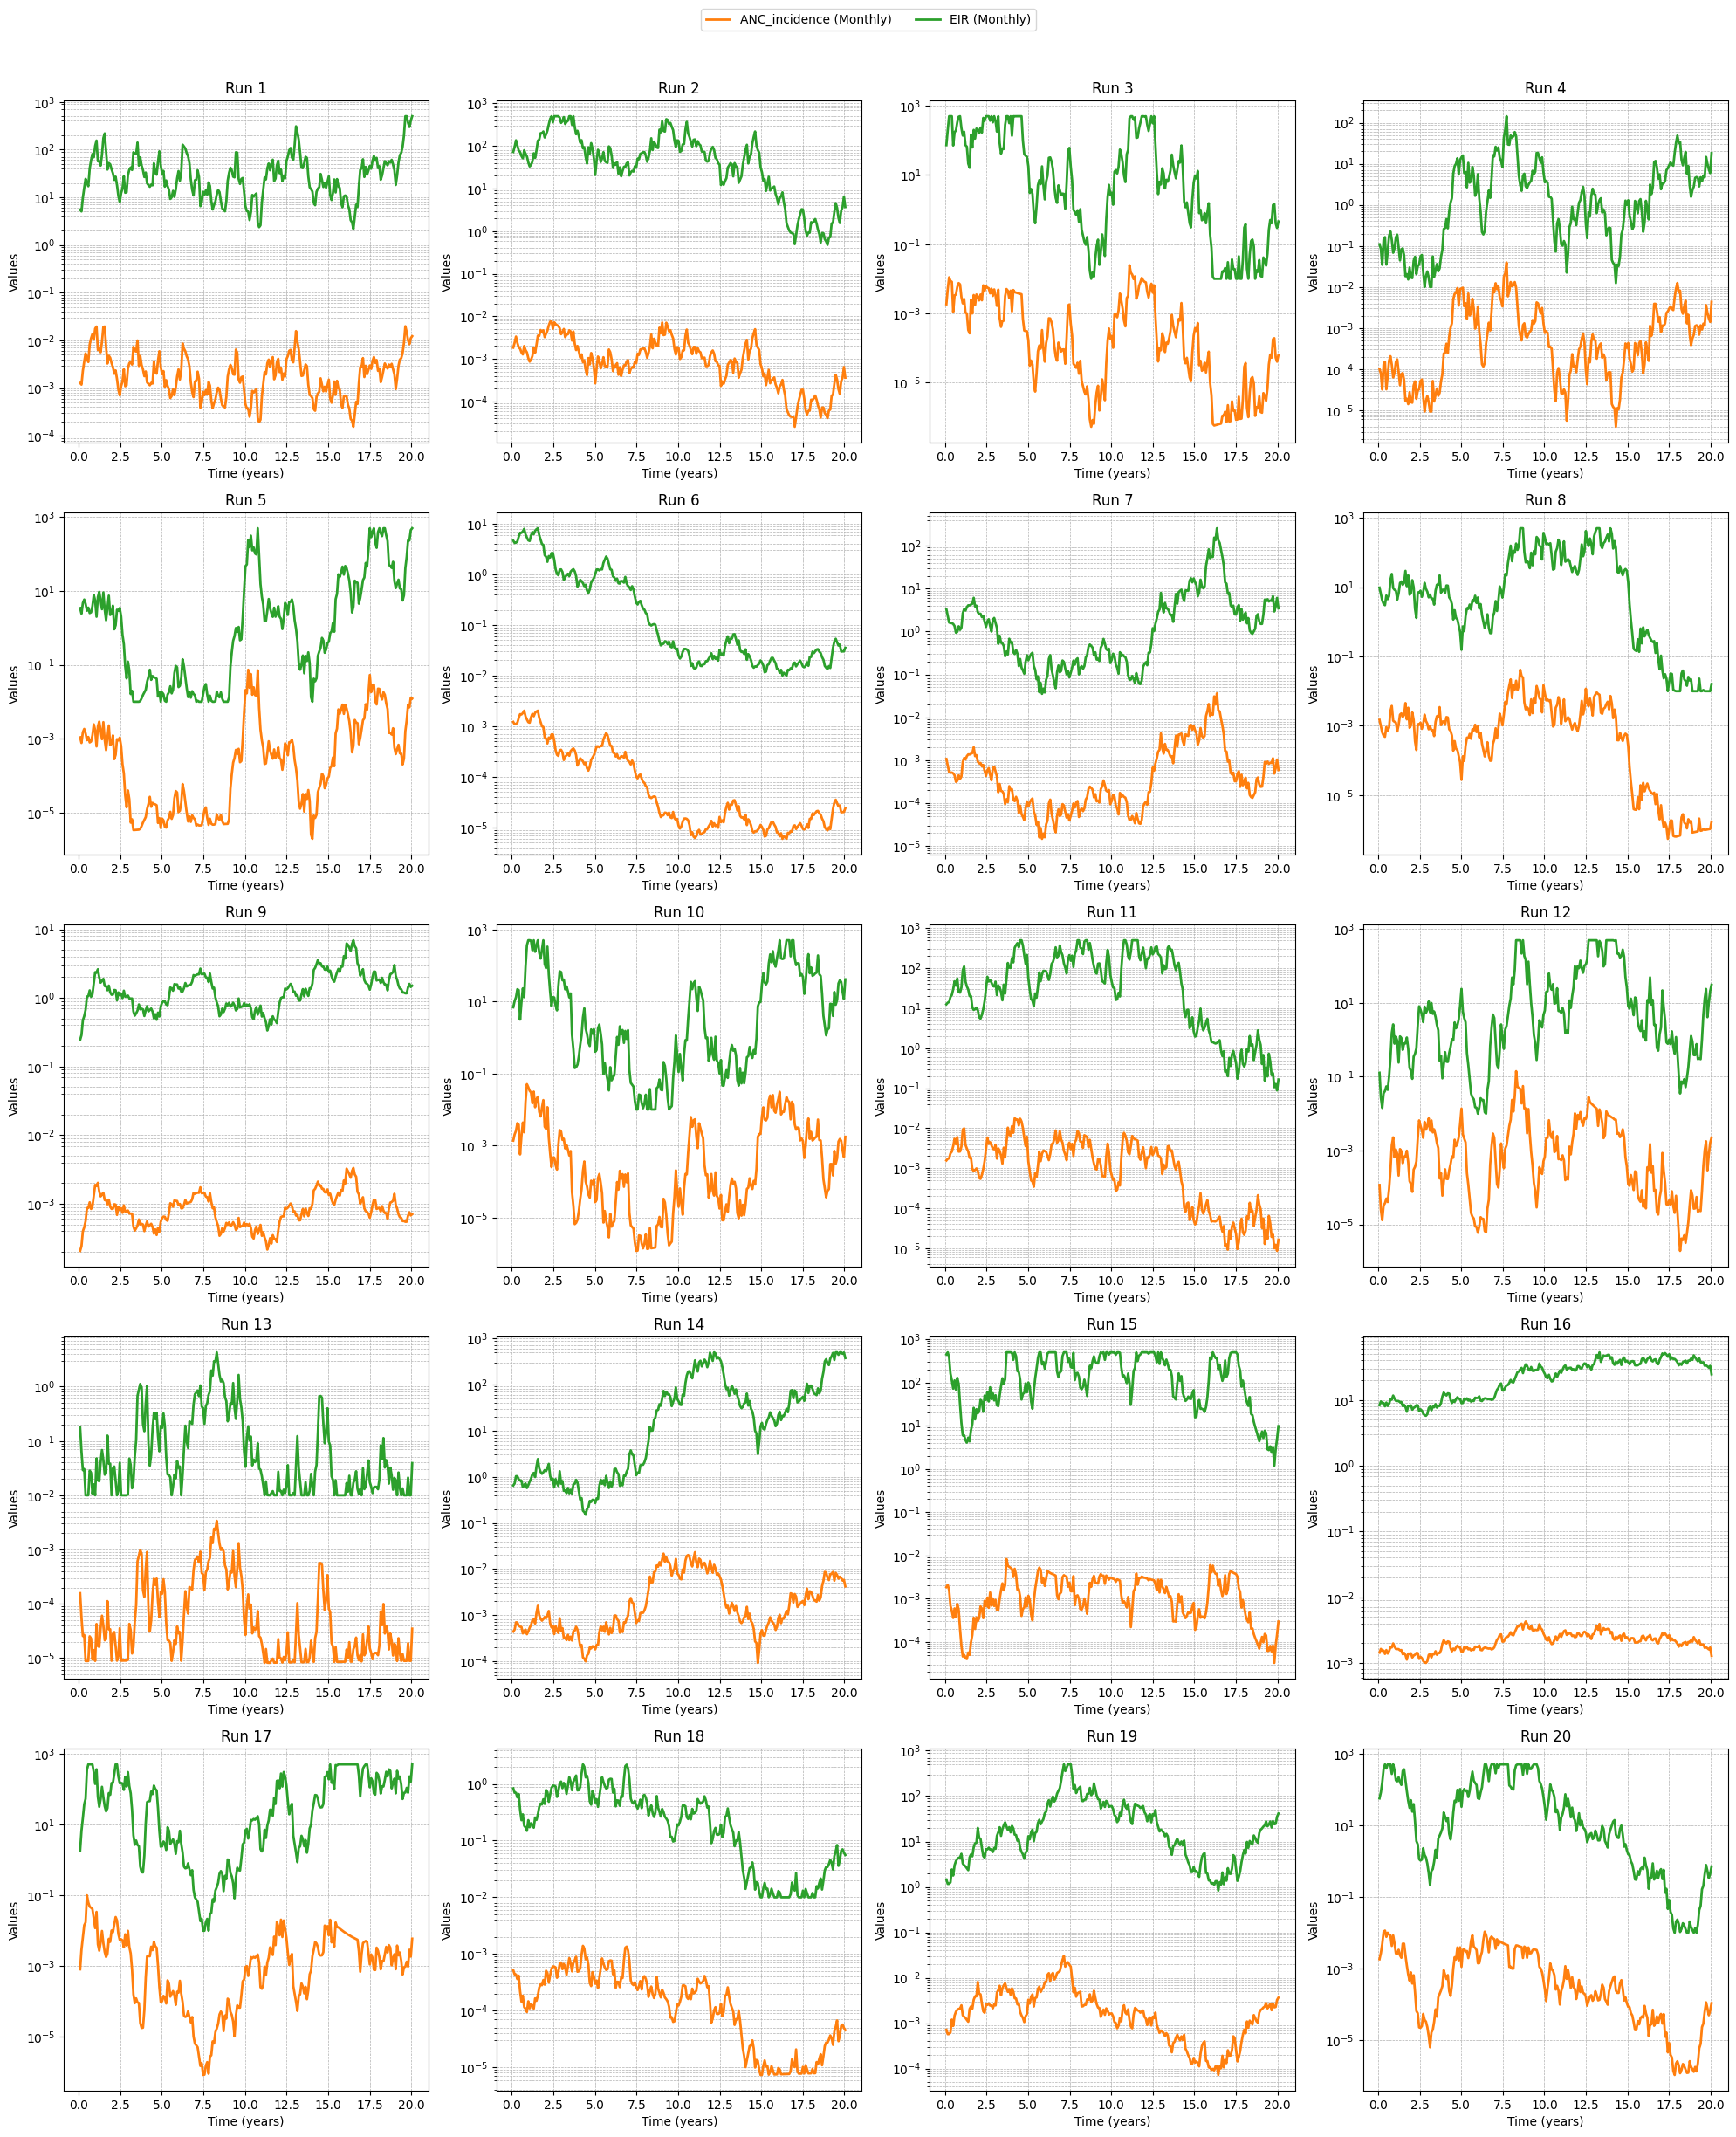

In [ ]:
plot_subplots_for_runs(df, num_runs=20)


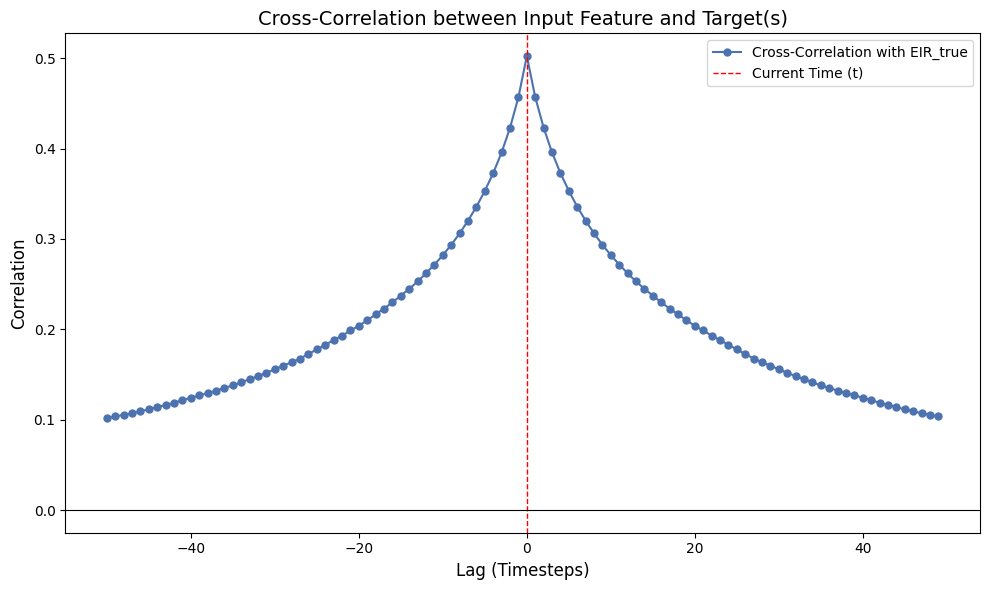

In [ ]:
plot_cross_correlation(df, 'incall', ['EIR_true'])

## Preprocessing

### Train-val-test split

In [ ]:
unique_runs = df['run'].unique()

np.random.seed(42)  # For reproducibility
np.random.shuffle(unique_runs)

In [ ]:
train_size = 6000
val_size = 2000
test_size = 2000

In [ ]:
# Assign runs to splits
train_runs = unique_runs[:train_size]
val_runs = unique_runs[train_size:train_size + val_size]
test_runs = unique_runs[train_size + val_size:]

In [ ]:
# Subset dataframe
train_df = df[df['run'].isin(train_runs)]
val_df = df[df['run'].isin(val_runs)]
test_df = df[df['run'].isin(test_runs)]

In [ ]:
cols_to_transform = ["incall", "EIR_true"]
log_transform = lambda x: np.log(x + 1e-8)

In [ ]:
train_data_scaled = train_df.copy()
val_data_scaled = val_df.copy()
test_data_scaled = test_df.copy()

for col in cols_to_transform:
    train_data_scaled[col] = log_transform(train_data_scaled[col])
    val_data_scaled[col] = log_transform(val_data_scaled[col])
    test_data_scaled[col] = log_transform(test_data_scaled[col])

In [ ]:
print(train_data_scaled.shape, val_data_scaled.shape, test_data_scaled.shape)

(1464000, 10) (488000, 10) (488000, 10)


In [ ]:
train_data_scaled.head()

,run,t,prev_true,EIR_true,vol_true,tested,positive,prev_2to10,inc_2to10,incall
0,1,30,0.196314,1.699292,0.5,192,33,0.255757,0.001794,-6.660031
1,1,60,0.196316,1.618635,0.5,271,58,0.255760,0.001655,-6.740692
2,1,90,0.194143,2.284779,0.5,225,30,0.252997,0.003231,-6.072096
3,1,120,0.216050,2.754400,0.5,204,42,0.280590,0.005010,-5.629062
4,1,150,0.249534,3.189657,0.5,182,49,0.322066,0.007403,-5.232149


### Functions to create sequences from time-series data

In [ ]:
import torch
import numpy as np

def create_sequences(data, window_size):
    """
    data: pd.DataFrame with columns ['incall','EIR_true']
    window_size: number of past timesteps to use as input

    Returns:
      X: FloatTensor of shape (N, window_size, 1)  — sequences of incall
      y: FloatTensor of shape (N, 1)               — the next EIR_true
    """
    inc = data['incall'].values
    eir = data['EIR_true'].values
    xs, ys = [], []

    # Slide window so that for each i:
    #   X[i] = inc[i : i+window_size]
    #   y[i] = eir[i + window_size]
    for i in range(len(data) - window_size):
        x_win = inc[i : i + window_size].reshape(window_size, 1)
        y_val = eir[i + window_size]

        xs.append(x_win)
        ys.append([y_val])

    # Stack into numpy then torch tensors
    X = torch.tensor(np.stack(xs), dtype=torch.float32)  # shape (N, window_size, 1)
    y = torch.tensor(np.stack(ys), dtype=torch.float32)  # shape (N, 1)

    return X, y


In [ ]:
#Specifying size inspired by cross-correlation
window_size = 5

#Creating sequences of tensors
X_train, y_train = create_sequences(train_data_scaled, window_size)
X_val, y_val = create_sequences(val_data_scaled, window_size)

In [ ]:
print(X_train.shape, y_train.shape)

torch.Size([1463995, 5, 1]) torch.Size([1463995, 1])


In [ ]:
# print example X_train
print(X_train[10])

tensor([[-4.5625],
        [-4.0387],
        [-3.9374],
        [-5.0694],
        [-4.9409]])


In [ ]:
print(y_train[10])

tensor([3.8293])


In [ ]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
eval_dataset = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=32, shuffle=False)

In [ ]:
X_train.shape

torch.Size([1463995, 5, 1])

## Model Architecture and Training

### Functions to train the model and model architecture

In [ ]:
#Function to define the ML model
class LSTMModel(nn.Module):
    def __init__(self, input_size, architecture):
        super(LSTMModel, self).__init__()
        self.lstm_layers = nn.ModuleList()
        for i, hidden_size in enumerate(architecture):
            self.lstm_layers.append(nn.LSTM(input_size if i == 0 else architecture[i - 1], hidden_size, batch_first=True))
        self.fc = nn.Linear(architecture[-1],1)

    def forward(self, x):
        for lstm in self.lstm_layers:
            x, _ = lstm(x)
        x = self.fc(x[:, -1, :])
        return x


#Function to train the model
def train_model(model, train_loader, eval_loader, model_name, epochs=25, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    loss_history = []
    eval_loss_history = []

    start_time = time.time()  # Track time

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)

        # Evaluation phase
        model.eval()
        eval_loss = 0
        with torch.no_grad():
            for X_val, y_val in eval_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val)
                eval_loss += criterion(val_outputs, y_val).item()

        avg_eval_loss = eval_loss / len(eval_loader)
        eval_loss_history.append(avg_eval_loss)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Eval Loss: {avg_eval_loss:.4f}")

    duration = time.time() - start_time  # Training duration

    # Save the trained model
    torch.save(model.state_dict(), f"/content/drive/MyDrive/MalariaEmulator/{model_name}_model.pth")
    print(f"Model saved as /content/drive/MyDrive/MalariaEmulator/{model_name}_model.pth")

    return model, loss_history, eval_loss_history, duration

In [ ]:
architectures = {
    "2_layers": [128, 64],
    #"3_layers": [200, 100, 50],
    #"4_layers": [256, 128, 64, 32],
    #"5_layers": [300, 200, 100, 50, 25]
    #"6_layers": [512, 256, 128, 64, 32]
}

In [ ]:
results = []
for name, architecture in architectures.items():
    print(f"Training model: {name}")
    model = LSTMModel(input_size=1, architecture=architecture)
    trained_model, loss_history, eval_loss_history, duration = train_model(model, train_loader, eval_loader, model_name=name)
    results.append({
        "name": name,
        "model": trained_model,
        "loss_history": loss_history,
        "eval_loss_history": eval_loss_history,
        "duration": duration
    })
print("Training complete!")


Training model: 2_layers
Epoch 1/25, Loss: 1.9341, Eval Loss: 1.9483
Epoch 2/25, Loss: 1.8559, Eval Loss: 1.8636
Epoch 3/25, Loss: 1.8400, Eval Loss: 1.8848
Epoch 4/25, Loss: 1.8314, Eval Loss: 1.8421
Epoch 5/25, Loss: 1.8260, Eval Loss: 1.8378
Epoch 6/25, Loss: 1.8219, Eval Loss: 1.8364
Epoch 7/25, Loss: 1.8186, Eval Loss: 1.8459
Epoch 8/25, Loss: 1.8161, Eval Loss: 1.8507
Epoch 9/25, Loss: 1.8140, Eval Loss: 1.8284
Epoch 10/25, Loss: 1.8123, Eval Loss: 1.8463
Epoch 11/25, Loss: 1.8106, Eval Loss: 1.8298
Epoch 12/25, Loss: 1.8089, Eval Loss: 1.8241
Epoch 13/25, Loss: 1.8074, Eval Loss: 1.8283
Epoch 14/25, Loss: 1.8064, Eval Loss: 1.8296
Epoch 15/25, Loss: 1.8050, Eval Loss: 1.8314
Epoch 16/25, Loss: 1.8039, Eval Loss: 1.8327
Epoch 17/25, Loss: 1.8030, Eval Loss: 1.8222
Epoch 18/25, Loss: 1.8022, Eval Loss: 1.8309
Epoch 19/25, Loss: 1.8012, Eval Loss: 1.8225
Epoch 20/25, Loss: 1.8005, Eval Loss: 1.8293
Epoch 21/25, Loss: 1.7999, Eval Loss: 1.8235
Epoch 22/25, Loss: 1.7993, Eval Loss: 1

### Model Evaluation

In [ ]:
#Function for plotting model losses
def plot_training_metrics(results):
    plt.figure(figsize=(10, 6))
    for result in results:
        plt.plot(result['loss_history'], label=f"{result['name']} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.title("Training Loss Over Epochs: ANC Data at Equilibrium")
    plt.legend()
    plt.savefig("/content/drive/MyDrive/MalariaEmulator/plots/model_perfomance/training_loss_1000.png")
    plt.show()


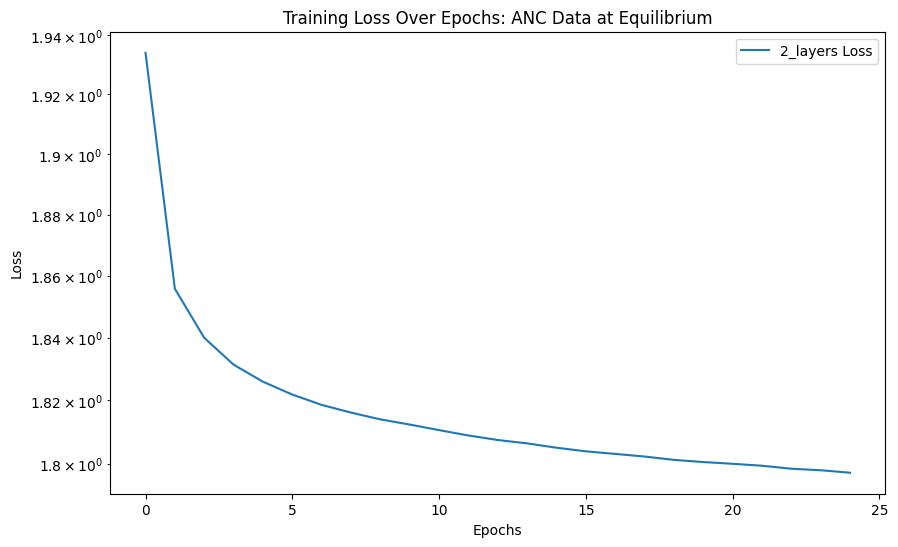

In [ ]:
#Plot loss function
plot_training_metrics(results)

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/MalariaEmulator')

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D


#Function to plot simulated data (Exploratory Data Analysis)
def plot_subplots_for_runs(df, num_runs=20):
    # Convert time column to years
    df = df.copy()
    df['t_years'] = df['t'] / 365  # Convert days to years

    # Select the first num_runs unique runs
    unique_runs = df['run'].unique()[:num_runs]
    columns_to_plot = ["incall", "EIR_true"]

    # Define distinct colors for the three columns
    color_map = {
        'incall': 'tab:orange',
        'EIR_true': 'tab:green'
    }

    # Define grid size for subplots (4 subplots per row)
    rows = (num_runs - 1) // 4 + 1
    cols = 4

    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    axes = axes.flatten()  # Flatten for easy iteration

    for i, run in enumerate(unique_runs):
        ax = axes[i]

        # Extract and sort data for the run by time
        run_data = df[df['run'] == run].sort_values('t_years')
        monthly = run_data.sort_values('t_years')

        # Plot monthly observation data as lines for each column
        for col in columns_to_plot:
            # Plot the monthly data as a solid line
            ax.plot(monthly['t_years'], monthly[col],
                    color=color_map[col],
                    lw=2,
                    label=f'{col} (Monthly)' if i == 0 else None)

        # Set the y-axis to a logarithmic scale for better comparison
        ax.set_yscale('log')

        # Set subplot title and labels
        ax.set_title(f'Run {run}')
        ax.set_xlabel('Time (years)')  # Updated label
        ax.set_ylabel('Values')
        ax.grid(True, which="both", ls="--", linewidth=0.5)

    # Hide any unused subplots
    for j in range(len(unique_runs), len(axes)):
        axes[j].axis('off')

    # Create a custom legend.
    custom_lines = [
        Line2D([0], [0], color=color_map['incall'], lw=2),
        Line2D([0], [0], color=color_map['EIR_true'], lw=2),
        Line2D([0], [0], marker='D', color='w', markerfacecolor='grey', markeredgecolor='k', markersize=10),
        Line2D([0], [0], color='grey', linestyle='--', lw=1.5)
    ]
    custom_labels = [
        'ANC_incidence (Monthly)',
        'EIR (Monthly)',
    ]

    # Place the universal legend at the top center
    fig.legend(custom_lines, custom_labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0.98))

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to provide space for the legend
    plt.savefig('drive/MyDrive/MalariaEmulator/plots/data_exploration/ANC_Params_Plot_Unobserved_Observed_Phase.png', dpi=300, bbox_inches='tight')
    plt.show()


#Function for plotting/checking cross cross correlation between inputs and targets
def plot_cross_correlation(df, input_col, target_cols, lags=range(-50, 50), single_target=None):
    """
    Computes and plots cross-correlation between an input feature and one or multiple target features.

    Parameters:
    df : pandas.DataFrame
        The DataFrame containing input and target features.
    input_col : str
        Column name of the input feature.
    target_cols : list
        List of column names for target features.
    lags : range, optional
        Range of lag values for correlation computation (default is -50 to 50).
    single_target : str, optional
        If specified, plots only the cross-correlation with this single target feature.
    """

    input_feature = df[input_col]
    targets = {col: df[col] for col in target_cols}

    results = {}
    for name, target in targets.items():
        correlations = []
        for lag in lags:
            shifted_input = input_feature.shift(-lag) if lag < 0 else input_feature.shift(lag)
            corr = target.corr(shifted_input)
            correlations.append(corr)
        results[name] = correlations

    # What to plot
    plot_targets = {single_target: results[single_target]} if single_target else results

    # Plotting
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("deep", len(plot_targets))

    for (name, correlations), color in zip(plot_targets.items(), colors):
        plt.plot(lags, correlations, marker='o', label=f'Cross-Correlation with {name}', color=color, markersize=5)

    plt.axvline(0, color='red', linestyle='--', linewidth=1, label='Current Time (t)')
    plt.axhline(0, color='black', linestyle='-', linewidth=0.8)

    plt.xlabel('Lag (Timesteps)', fontsize=12)
    plt.ylabel('Correlation', fontsize=12)
    plt.title('Cross-Correlation between Input Feature and Target(s)', fontsize=14)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.savefig('plots/data_exploration/Cross-Correlation_plots_between_prevalence_incidence_and_EIR.png')
    plt.show()


#Function for plotting model losses
def plot_training_metrics(results):
    plt.figure(figsize=(10, 6))
    for result in results:
        plt.plot(result['loss_history'], label=f"{result['name']} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.title("Training Loss Over Epochs: ANC Data at Equilibrium")
    plt.legend()
    plt.savefig("plots/model_performance/training_loss_25000runs_at_ Equilibrium.png")
    plt.show()


#Function for comparing model parameters and training timelines
def plot_model_comparison(results):
    model_names = [result['name'] for result in results]
    parameters = [sum(p.numel() for p in result['model'].parameters()) for result in results]
    durations = [result['duration'] for result in results]

    max_params = max(parameters)
    max_durations = max(durations) if max(durations) > 0 else 1

    normalized_params = [p / max_params for p in parameters]
    normalized_durations = [d / max_durations for d in durations]

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(12, 8))
    x = np.arange(len(model_names))
    bar_width = 0.4

    bar1 = ax.bar(x - bar_width / 2, normalized_params, bar_width, label="Normalized Parameters", color="skyblue")
    bar2 = ax.bar(x + bar_width / 2, normalized_durations, bar_width, label="Normalized Training Duration (sec)", color="darkorange")

    for bar, param in zip(bar1, parameters):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{param}', ha='center', va='bottom', fontsize=12, color="blue")
    for bar, duration in zip(bar2, durations):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{duration:.1f}', ha='center', va='bottom', fontsize=12, color="orange")

    ax.set_xlabel("Model")
    ax.set_ylabel("Normalized Values")
    ax.set_title("Comparison of Model Parameters and Training Durations: ANC at Equilibrium")
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, fontsize=10)
    ax.legend()

    plt.savefig("/content/drive/MyDrive/MalariaEmulator/plots/model_perfomance/model_comparison_1000runs_at_Equilibrium.png")
    plt.show()


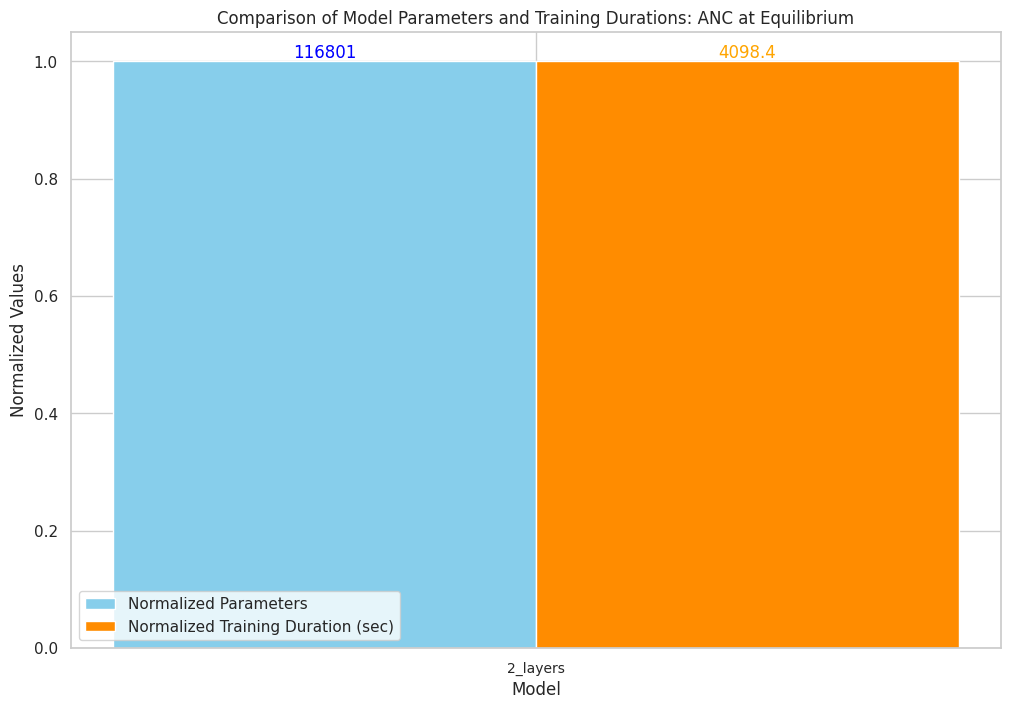

In [ ]:
#Plot model parameters and training duration
plot_model_comparison(results)

In [ ]:
results

[{'name': '2_layers',
  'model': LSTMModel(
    (lstm_layers): ModuleList(
      (0): LSTM(1, 128, batch_first=True)
      (1): LSTM(128, 64, batch_first=True)
    )
    (fc): Linear(in_features=64, out_features=1, bias=True)
  ),
  'loss_history': [1.9340752222668278,
   1.8558759105811353,
   1.84002413962643,
   1.8313980132321843,
   1.8259567030635688,
   1.8218557499770909,
   1.818565951237913,
   1.8161192223778189,
   1.81396297254849,
   1.812325426975886,
   1.8105564365386964,
   1.80886643624436,
   1.807431995686286,
   1.8063653711464887,
   1.8049974950701813,
   1.8038596726349794,
   1.803045944974722,
   1.8022201872497308,
   1.8011618724227603,
   1.8004845087834396,
   1.7999268710965015,
   1.7993191824180832,
   1.7983770020920071,
   1.79789899425233,
   1.7971212557651957],
  'eval_loss_history': [1.9482605191003837,
   1.8636459587345846,
   1.8848360951033527,
   1.8421137814949282,
   1.8377880110454852,
   1.836350712134335,
   1.8459122332479865,
   1.850



```
# This is formatted as code
```

### Model Evaluation and Inferencing

In [ ]:
len(y_train)

1463995

In [ ]:
len(y_val)

487995

In [ ]:
from src.evaluate import predict_in_batches, plot_performance_metrics

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#Process inferences in batches (avoiding GPU memory issue)
def predict_in_batches(model, X, batch_size=512, device='cpu'):
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i + batch_size].to(device)
            preds = model(X_batch).cpu().numpy()
            predictions.append(preds)
    return np.vstack(predictions)


#Function to Plot Evaluation Metrics
def plot_performance_metrics(results, X_train, y_train, X_eval, y_eval):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    y_train_pred_list = [
        predict_in_batches(result['model'], X_train, batch_size=512, device=device) for result in results
    ]

    y_eval_pred_list = [
        predict_in_batches(result['model'], X_eval, batch_size=512, device=device) for result in results
    ]

    metrics_data = []
    for idx, result in enumerate(results):
        y_train_pred = y_train_pred_list[idx]
        y_eval_pred = y_eval_pred_list[idx]

        train_r2 = r2_score(y_train, y_train_pred)
        eval_r2 = r2_score(y_eval, y_eval_pred)
        train_mse = mean_squared_error(y_train, y_train_pred)
        eval_mse = mean_squared_error(y_eval, y_eval_pred)
        train_rmse = np.sqrt(train_mse)
        eval_rmse = np.sqrt(eval_mse)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        eval_mae = mean_absolute_error(y_eval, y_eval_pred)

        metrics_data.append({
            "Model": result['name'],
            "Train R²": train_r2, "Eval R²": eval_r2,
            "Train MSE": train_mse, "Eval MSE": eval_mse,
            "Train RMSE": train_rmse, "Eval RMSE": eval_rmse,
            "Train MAE": train_mae, "Eval MAE": eval_mae
        })

    metrics_df = pd.DataFrame(metrics_data)
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # R² Plot with value annotations
    ax = sns.barplot(data=metrics_df.melt(id_vars="Model", value_vars=["Train R²", "Eval R²"]),
                     x="Model", y="value", hue="variable", palette="viridis", ax=axes[0, 0])
    axes[0, 0].set_title("R² Score Comparison:Starting_at_Equilibrium")
    axes[0, 0].set_ylabel("R² Score")
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', padding=-25, color='white', fontsize =10)

    # MSE Plot
    sns.barplot(data=metrics_df.melt(id_vars="Model", value_vars=["Train MSE", "Eval MSE"]),
                x="Model", y="value", hue="variable", palette="magma", ax=axes[0, 1])
    axes[0, 1].set_title("Mean Squared Error (MSE) Comparison:Starting_at_Equilibrium")
    axes[0, 1].set_ylabel("MSE")

    # RMSE Plot
    sns.barplot(data=metrics_df.melt(id_vars="Model", value_vars=["Train RMSE", "Eval RMSE"]),
                x="Model", y="value", hue="variable", palette="coolwarm", ax=axes[1, 0])
    axes[1, 0].set_title("Root Mean Squared Error (RMSE) Comparison:Starting_at_Equilibrium")
    axes[1, 0].set_ylabel("RMSE")

    # MAE Plot
    sns.barplot(data=metrics_df.melt(id_vars="Model", value_vars=["Train MAE", "Eval MAE"]),
                x="Model", y="value", hue="variable", palette="cividis", ax=axes[1, 1])
    axes[1, 1].set_title("Mean Absolute Error (MAE) Comparison:Starting_at_Equilibrium")
    axes[1, 1].set_ylabel("MAE")

    fig.tight_layout()
    plt.savefig("/content/drive/MyDrive/MalariaEmulator/plots/test_prediction/performance_metrics_1000runs_at_Equilibrium.png")
    plt.show()


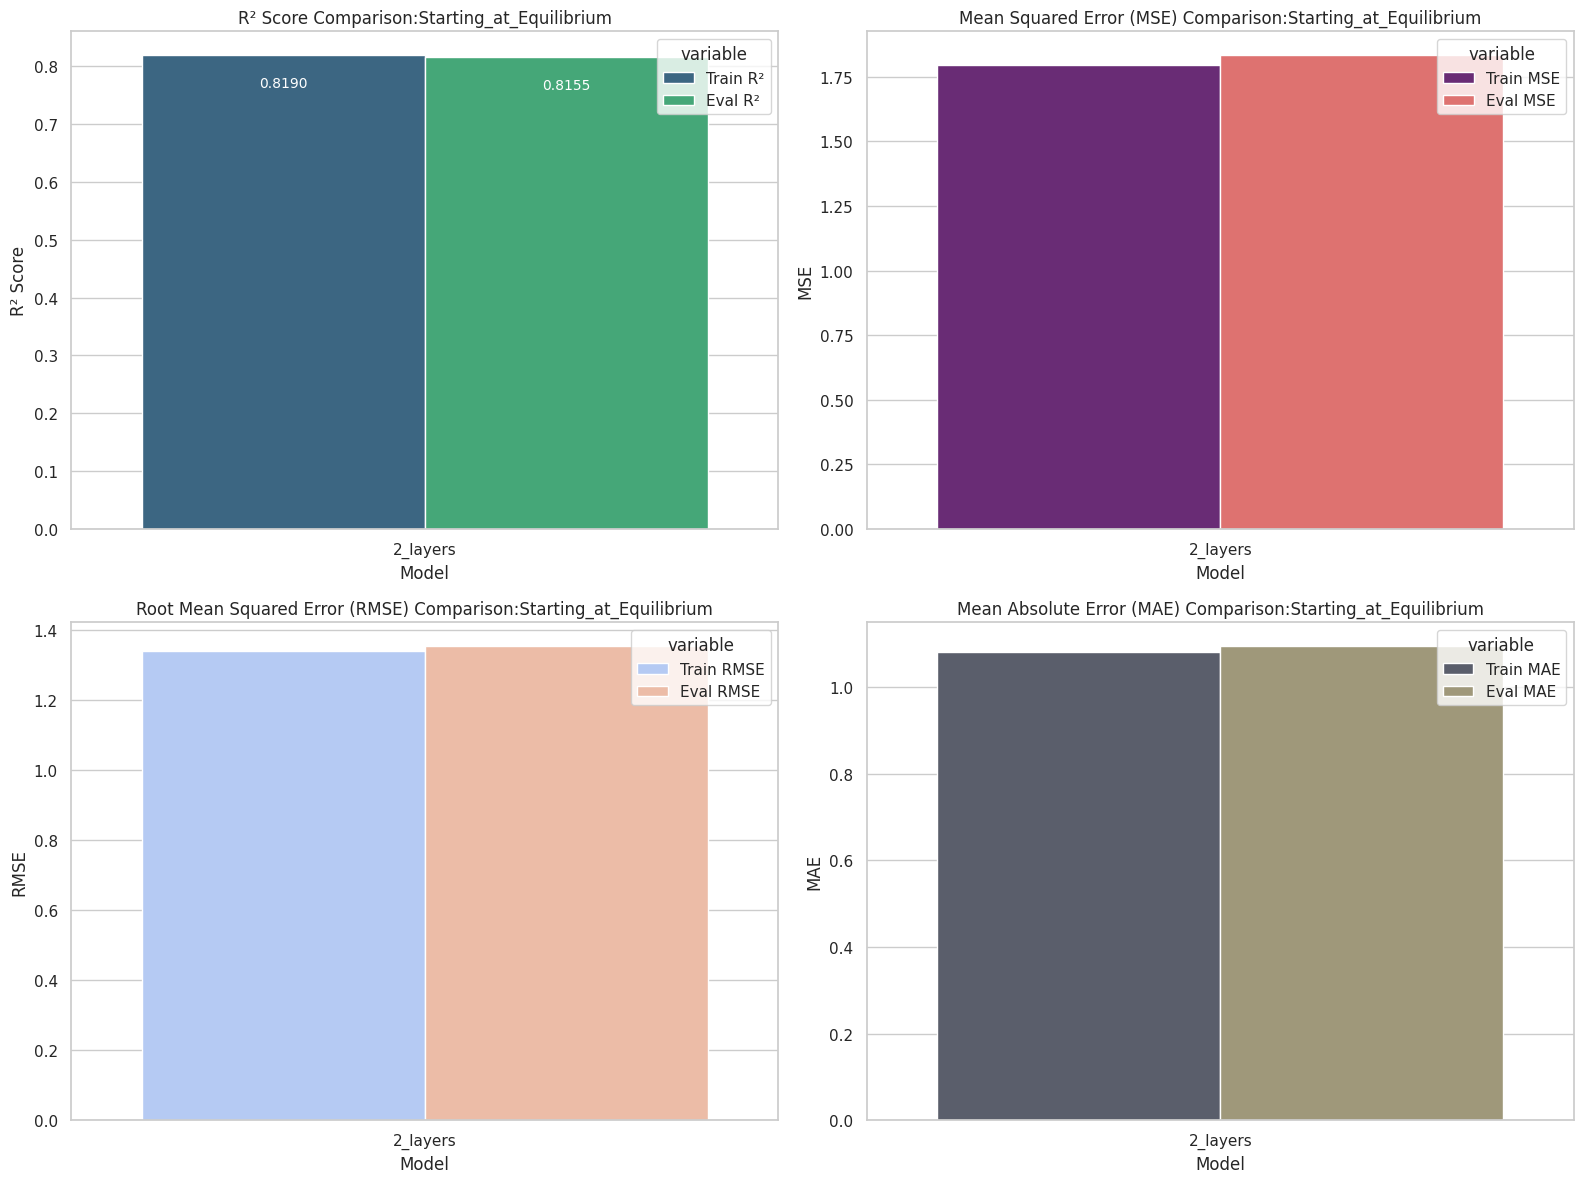

In [ ]:
#Compare Model Performance across train models
plot_performance_metrics(results, X_train, y_train, X_val, y_val)

###Inference on Test Set

In [ ]:
#from src.inference import test_model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function for making predictions and plotting results
def test_model(model_path, test_data, window_size, num_runs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    arch = [256, 128, 64, 32]
    model = LSTMModel(input_size=1, architecture=arch)
    model.fc = nn.Linear(arch[-1], 1)              # ← force 1-D output
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    log_transform = lambda x: np.log(x + 1e-8)
    inverse_log_transform = lambda x: np.exp(x) - 1e-8

    unique_runs = np.random.choice(test_data['run'].unique(), num_runs, replace=False)

    # Calculate subplot grid dimensions
    num_plots = len(unique_runs)
    num_cols = int(np.ceil(np.sqrt(num_plots)))
    num_rows = int(np.ceil(num_plots / num_cols))

    # Create subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), sharey='row')

    axs = axs.flatten() if num_rows * num_cols > 1 else [axs]
    handles, labels = [], []

    for i, run in enumerate(unique_runs):
        run_data = test_data[test_data['run'] == run]
        scaled_run_data = run_data[['EIR_true', 'incall']].apply(log_transform)
        X_test_scaled, y_test_scaled = create_sequences(scaled_run_data, window_size)

        X_test_scaled = X_test_scaled.to(device)
        with torch.no_grad():
            test_predictions_scaled = model(X_test_scaled).cpu().numpy()

        # Unscale the predictions for plotting
        y_test_unscaled = inverse_log_transform(y_test_scaled.numpy())
        test_predictions_unscaled = inverse_log_transform(test_predictions_scaled)

        # Extract the time column and scale it
        time_column = run_data['t'].values[:len(test_predictions_scaled)]
        time_in_years = time_column / 365.25

        # Discard points before 10 years
        #valid_indices = np.where(time_in_years >= 10)[0]
        #time_in_years = time_in_years[valid_indices]
        #y_test_scaled = y_test_scaled.numpy()[valid_indices]
        #y_test_unscaled = y_test_unscaled[valid_indices]
        #test_predictions_scaled = test_predictions_scaled[valid_indices]
        #test_predictions_unscaled = test_predictions_unscaled[valid_indices]

        # Compute error metrics for **scaled** test data
        mse_eir = mean_squared_error(y_test_scaled[:, 0], test_predictions_scaled[:, 0])
        mae_eir = mean_absolute_error(y_test_scaled[:, 0], test_predictions_scaled[:, 0])
        r2_eir = r2_score(y_test_scaled[:, 0], test_predictions_scaled[:, 0])

        #mse_inc = mean_squared_error(y_test_scaled[:, 1], test_predictions_scaled[:, 1])
        #mae_inc = mean_absolute_error(y_test_scaled[:, 1], test_predictions_scaled[:, 1])
        #r2_inc = r2_score(y_test_scaled[:, 1], test_predictions_scaled[:, 1])

        # Define a professional color palelr=0.001)tte
        true_color = "black"
        pred_color_eir = "#ff7f0e"  # Bright Orange for EIR_true prediction
        #pred_color_inc = "#d62728"  # Muted Red for Incidence prediction

        # Plot true and predicted values with distinct colors (using unscaled predictions for plot)
        axs[i].plot(time_in_years, y_test_unscaled[:, 0], label="True EIR_true", color=true_color, linestyle='-')
        axs[i].plot(time_in_years, test_predictions_unscaled[:, 0], label="Predicted EIR_true", color=pred_color_eir, linestyle='--')

        #axs[i].plot(time_in_years, y_test_unscaled[:, 1], label="True Incidence", color=true_color, linestyle='-')
        #axs[i].plot(time_in_years, test_predictions_unscaled[:, 1], label="Predicted Incidence", color=pred_color_inc, linestyle='--')

        # Set y-axis to log scale
        axs[i].set_yscale('log')

        # Set x-axis label
        axs[i].set_xlabel("Years")

        # Display title with metrics beside it
        axs[i].set_title(
            f'Run {run}  |  MSE: {mse_eir:.3f}, MAE: {mae_eir:.3f}, R²: {r2_eir:.3f}',
            fontsize=10, loc="left"
        )

        # Enable only vertical grid lines
        axs[i].grid(True, axis='x', linestyle='--', linewidth=0.5, alpha=0.7)

        # Collect handles and labels for universal legend
        if i == 0:
            handles, labels = axs[i].get_legend_handles_labels()

    # Universal plot title
    fig.suptitle("EIR Predictions for Observation Period:Starting_at_Equilibrium", fontsize=16, fontweight="bold", y=0.96)

    # Remove any empty subplots
    for j in range(num_plots, len(axs)):
        fig.delaxes(axs[j])

    # Add universal legend
    fig.legend(handles, labels, loc='upper center', ncol=4)

    # Adjust layout and display/save plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("/content/drive/MyDrive/MalariaEmulator/plots/test_prediction_EIR_only.png")
    plt.show()





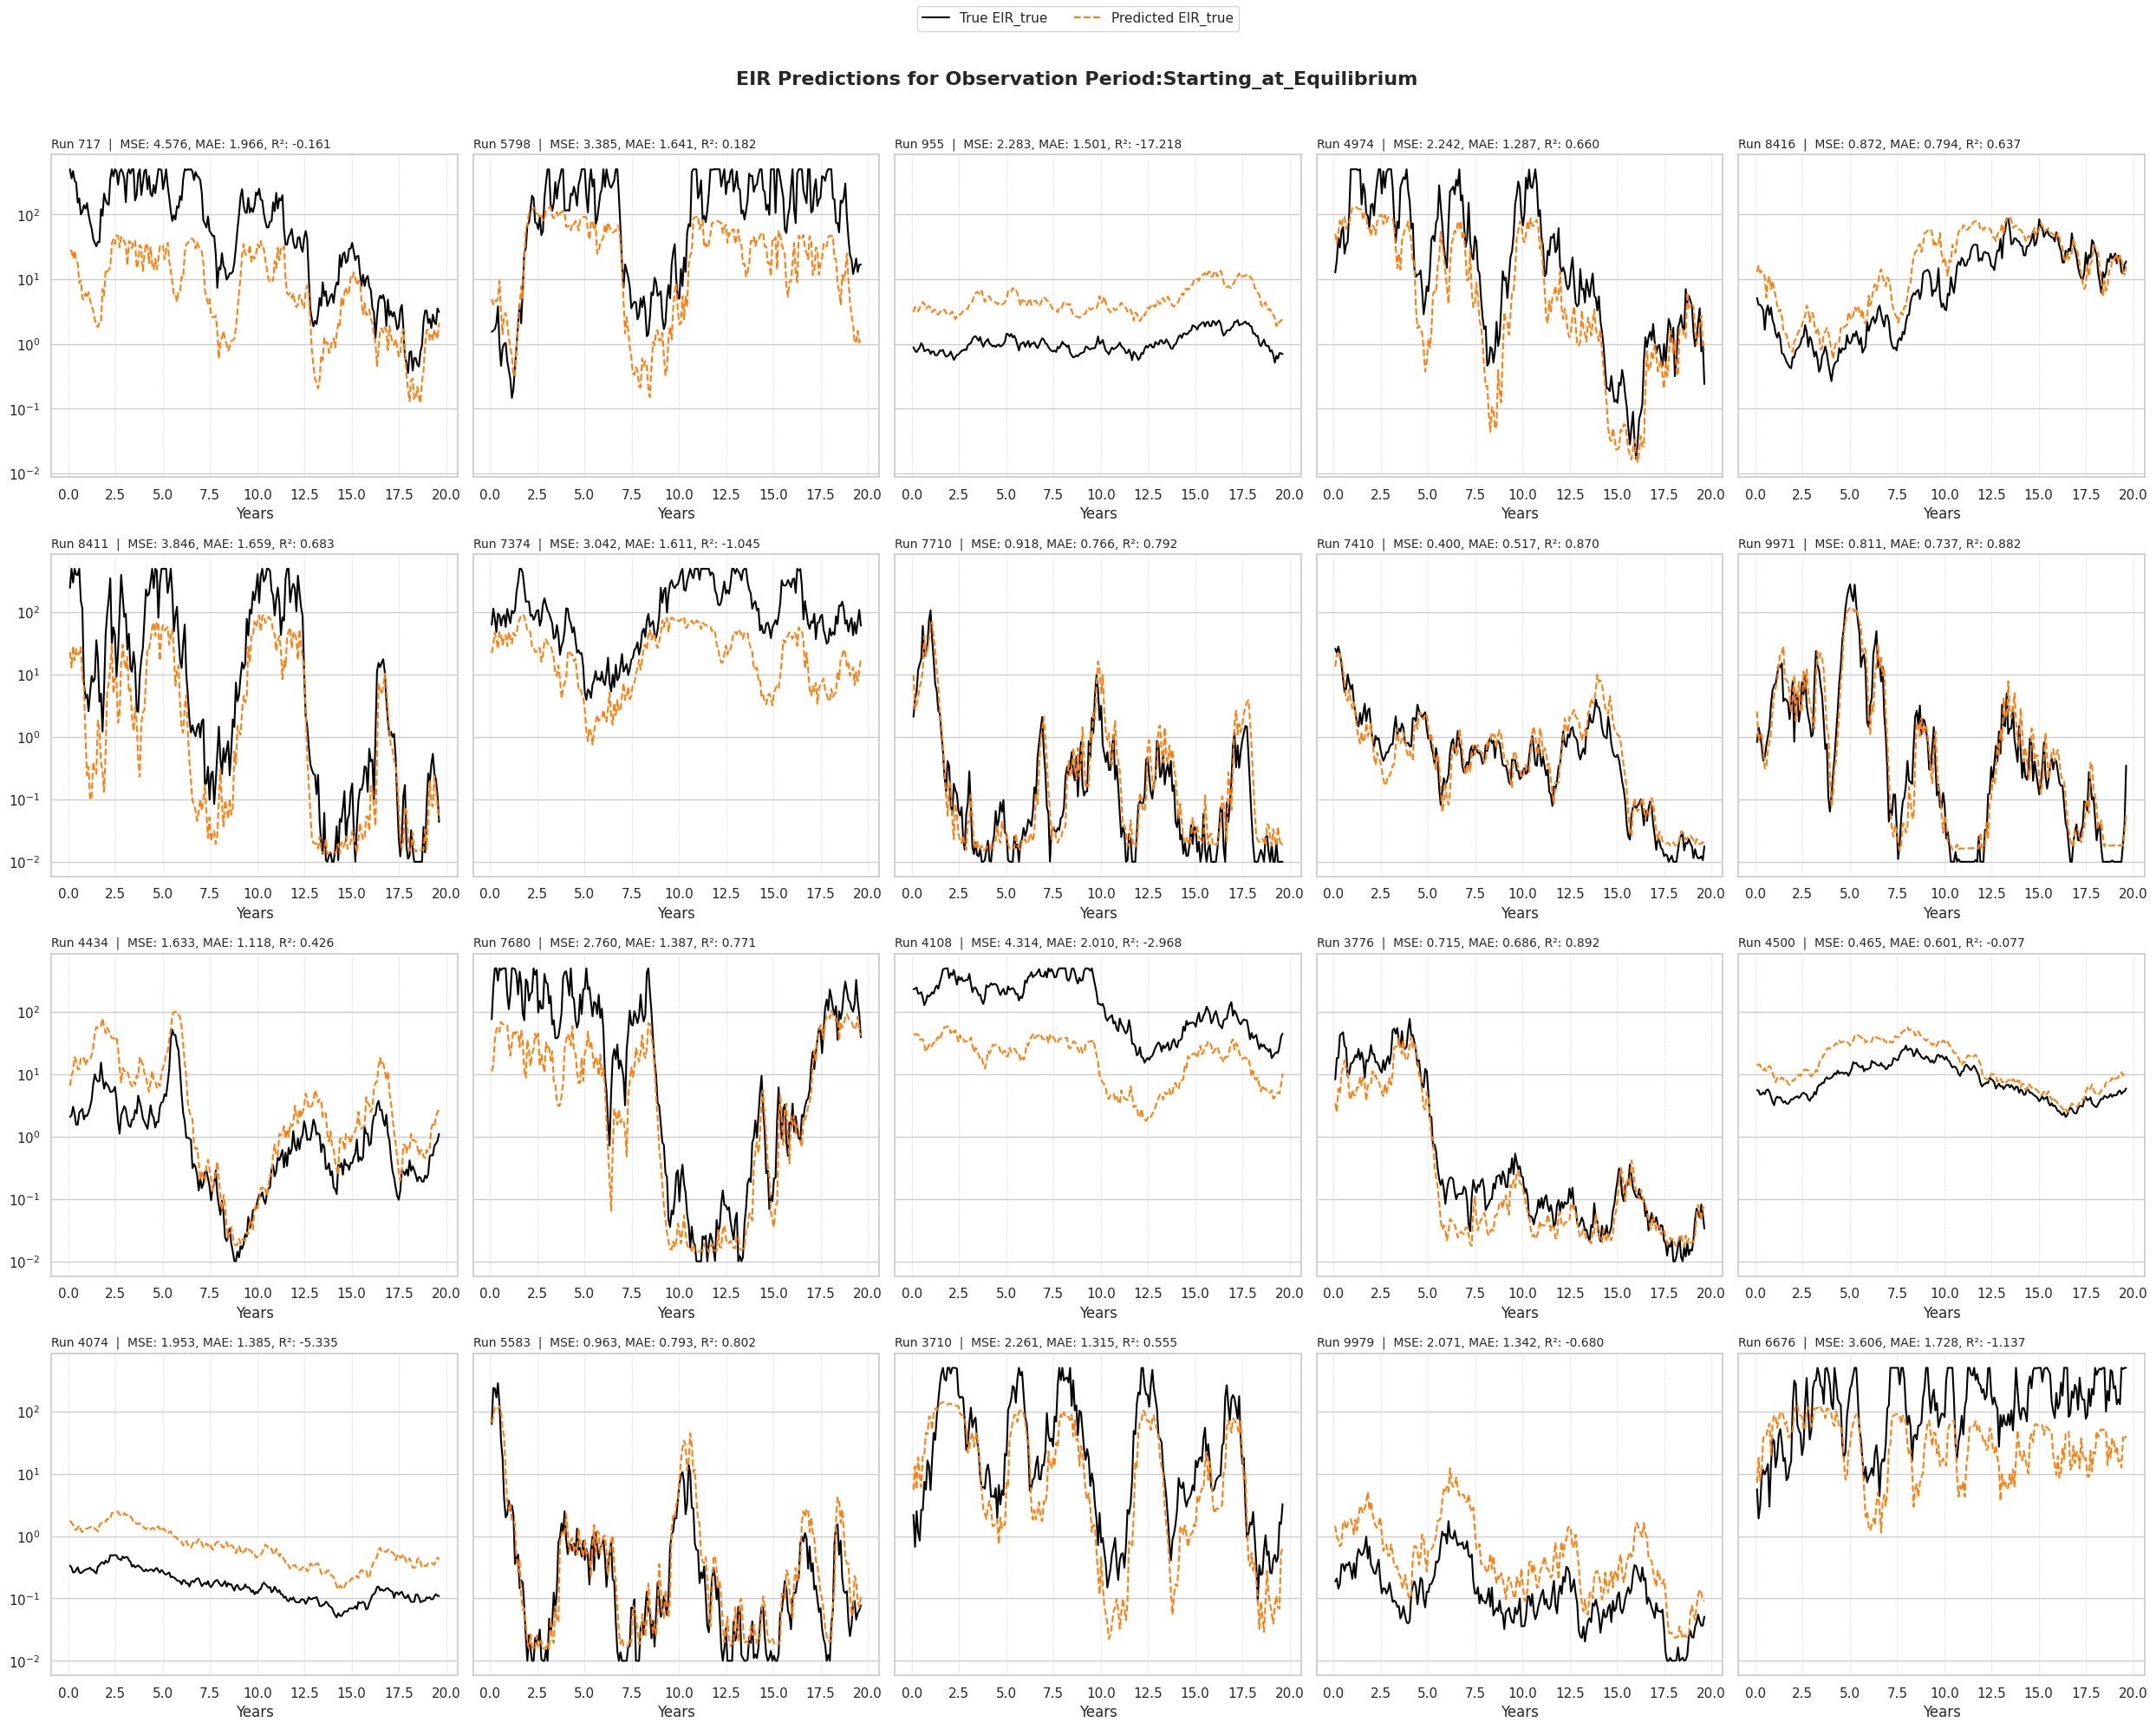

In [ ]:
test_model("/content/drive/MyDrive/MalariaEmulator/4_layers_model.pth",test_df,window_size=5,num_runs=20)


###Test Metrics Evaluation

In [ ]:
#from src.test import calculate_metrics, plot_performance_metrics

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import torch
import pandas as pd

# Function to calculate metrics for each model
def calculate_metrics(model, test_data, window_size, device):
    log_transform = lambda x: np.log(x + 1e-8)
    inverse_log_transform = lambda x: np.exp(x) - 1e-8

    scaled_test_data = test_data[['EIR_true', 'incall']].apply(log_transform)
    X_test_scaled, y_test_scaled = create_sequences(scaled_test_data, window_size)

    X_test_scaled = X_test_scaled.to(device)
    with torch.no_grad():
        test_predictions_scaled = model(X_test_scaled).cpu().numpy()

    #y_test_unscaled = inverse_log_transform(y_test_scaled.numpy())
    #test_predictions_unscaled = inverse_log_transform(test_predictions_scaled)

    mse = mean_squared_error(y_test_scaled, test_predictions_scaled)
    mae = mean_absolute_error(y_test_scaled, test_predictions_scaled)
    r2 = r2_score(y_test_scaled, test_predictions_scaled)

    return mse, mae, r2


# Function to plot metrics per model
def plot_performance_metrics(test_data, window_size, model_paths):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    metrics = {'Model': [], 'MSE': [], 'MAE': [], 'R²': []}

    for model_name, model_path in model_paths.items():
        architecture = model_architectures[model_name]
        model = LSTMModel(input_size=1, architecture=architecture)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()

        mse, mae, r2 = calculate_metrics(model, test_data, window_size, device)

        metrics['Model'].append(model_name)
        metrics['MSE'].append(mse)
        metrics['MAE'].append(mae)
        metrics['R²'].append(r2)

    df = pd.DataFrame(metrics)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    metrics_to_plot = ['MSE', 'MAE', 'R²']

    for i, metric in enumerate(metrics_to_plot):
        sns.boxplot(x='Model', y=metric, data=df, ax=axes[i])
        axes[i].set_title(f'{metric} Across Models on Test Set: Equilibrium')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

    plt.tight_layout()
    #fig.suptitle("Metrics Comparison on Test Set", fontsize=16)
    plt.savefig("/content/drive/MyDrive/MalariaEmulator/plots/model_perfomance/box_plot_test_predictions_at_Equilibrium.png")
    plt.show()



In [ ]:
# Define model architectures
model_architectures = {
    "2_layers": [128, 64],
    #"3_layers": [200, 100, 50],
    #"4_layers": [256, 128, 64, 32],
    #"5_layers": [300, 200, 100, 50, 25]
}

# Model paths
model_paths = {
    "2_layers": "/content/drive/MyDrive/MalariaEmulator/2_layers_model.pth",
    "3_layers": "/content/drive/MyDrive/MalariaEmulator/3_layers_model.pth",
    "4_layers": "/content/drive/MyDrive/MalariaEmulator/4_layers_model.pth",
    "5_layers": "/content/drive/MyDrive/MalariaEmulator/5_layers_model.pth"
}


#  Ploting aggregated Test Metrics
plot_performance_metrics(test_df, window_size=5, model_paths=model_paths)

OutOfMemoryError: CUDA out of memory. Tried to allocate 26.32 GiB. GPU 0 has a total capacity of 14.74 GiB of which 11.96 GiB is free. Process 5742 has 2.78 GiB memory in use. Of the allocated memory 2.61 GiB is allocated by PyTorch, and 38.37 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
#import numpy as np
#import matplotlib.pyplot as plt
#from sklearn.metrics import auc

# CENTER & SCALE each run to [-1,1]
#def normalize_run_pp(g):
    #y = g['EIR_true'].values
    #p2p = y.max() - y.min()
    #if p2p == 0:
        # flat line → skip it
        #g['EIR_true_norm'] = 0
        #g['EIR_pred_norm'] = 0
        #return g

    #mean = y.mean()
    # center then scale so max|y| → 1
    #g['EIR_true_norm'] = (g['EIR_true'] - mean) / (p2p/2)
    #g['EIR_pred_norm'] = (g['EIR_pred'] - mean) / (p2p/2)
    #return g

#df_norm = df_pred.groupby('run').apply(normalize_run_pp).reset_index(drop=True)

# COMPUTE SEASONALITY INDEX = AUC of |true_norm| over t_norm∈[0,1]
#def seasonality_index(df):
    #idxs = {}
    #for run, g in df.groupby('run'):
        #t = g['t'].values
        #tn = (t - t.min()) / (t.max() - t.min())      # map time to [0,1]
        #y = np.abs(g['EIR_true_norm'].values)         # absolute deviation
        #idxs[run] = auc(tn, y)                       # area under |y|
    #return pd.Series(idxs)

#aucs = seasonality_index(df_norm)

# PICK 5 archetypes as before
#sr = aucs.sort_values()
#n  = len(sr)
#archetypes = [
    #sr.index[0],      # flattest
    #sr.index[-1],     # most seasonal
    #sr.index[n//2],   # median
    #sr.index[n//4],   # lower quartile
    #sr.index[3*n//4], # upper quartile
#]

# 10) PLOT normalized curves (shape only)
#fig, axes = plt.subplots(len(archetypes), 1, figsize=(8, 2.5*len(archetypes)), sharex=True)
#for ax, run_id in zip(axes, archetypes):
    #gr = df_norm[df_norm['run'] == run_id]
    #ax.plot(gr['t'], gr['EIR_true_norm'],  lw=2, label='True (norm)')
    #ax.plot(gr['t'], gr['EIR_pred_norm'], '--', lw=2, label='Pred (norm)')
    #ax.set_title(f'Run {run_id} (SI={aucs[run_id]:.3f})')
    #ax.set_ylabel('Norm’d EIR')
    #ax.legend(loc='upper right')
##axes[-1].set_xlabel('Time')
#plt.tight_layout()
#plt.show()
